# Importing required Packages

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer, OrdinalEncoder, LabelEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from dateutil.parser import parse
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
import ast
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
import nltk
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import time

# Data Cleaning

In [2]:
df = pd.read_csv('spam_1.csv', low_memory=False)

In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [4]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5163
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.shape

(5572, 2)

In [8]:
print(df['v2'][0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [9]:
null_counts = df.isnull().sum()
print(null_counts)

v1    0
v2    0
dtype: int64


In [10]:
dup_rows = df.duplicated().sum()
print(f"dup rows: {dup_rows}")

dup rows: 409


In [11]:
df = df.drop_duplicates()

In [12]:
df.shape

(5163, 2)

In [13]:
spam_counts = df['v1'].value_counts()

print("No of 0 (Non-Spam):", spam_counts.iloc[0])
print("No of 1 (Spam):", spam_counts.iloc[1])

No of 0 (Non-Spam): 4516
No of 1 (Spam): 647


# EDA

EDA 1: Bar Plot for No. of Spam/Non-spams

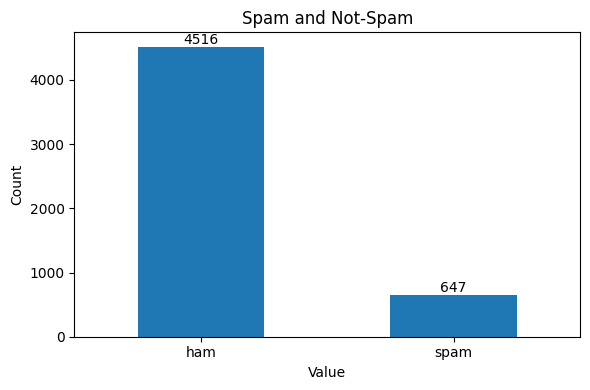

In [14]:
value_counts = df['v1'].value_counts()

plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar')
plt.title('Spam and Not-Spam')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, count in enumerate(value_counts):
   plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [15]:
stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by','is', 'i', 'how', 'it'])

def top_words(df, column, top_n=10, label=None):
   if label is not None:
       df = df[df['v1'] == label]
   
   all_text = ' '.join(df[column].fillna('').astype(str))
   all_text = all_text.lower()
   words = re.findall(r'\w+', all_text)
   filtered_words = [word for word in words if word not in stop_words]
   word_counts = Counter(filtered_words)
   top_words = word_counts.most_common(top_n)
   return top_words

In [16]:
le = LabelEncoder()
df['v1'] = le.fit_transform(df['v1'])

EDA 2: Top 20 Repeated Words(Non-Spam)

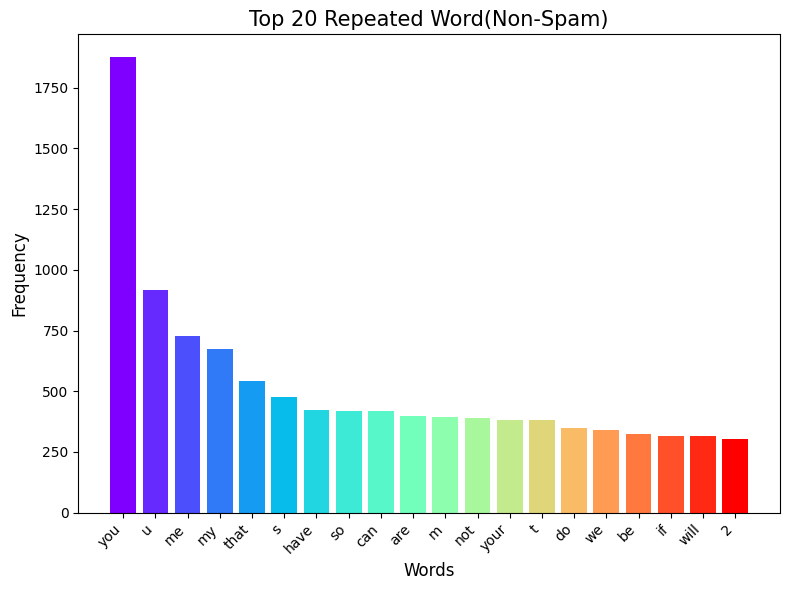

In [17]:
import matplotlib.cm as cm

top_non_spam = top_words(df, 'v2', top_n=20, label=0)
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(top_non_spam)))
plt.bar(
  [word[0] for word in top_non_spam], 
  [word[1] for word in top_non_spam], 
  color=colors
)
plt.title('Top 20 Repeated Word(Non-Spam)', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

EDA 3: Top 20 repeated words (Spam)

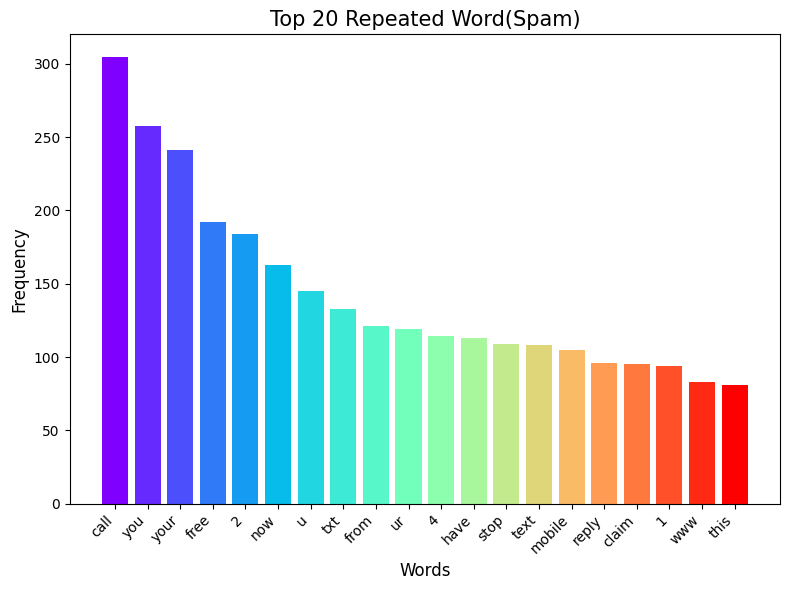

In [18]:
import matplotlib.cm as cm

top_non_spam = top_words(df, 'v2', top_n=20, label=1)
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(top_non_spam)))
plt.bar(
  [word[0] for word in top_non_spam], 
  [word[1] for word in top_non_spam], 
  color=colors
)
plt.title('Top 20 Repeated Word(Spam)', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Word Cloud

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [20]:
def create_wordcloud(words_freq , title):
  word_dict = dict(words_freq)
  wordcloud = WordCloud(
      width=400, 
      height=200, 
      background_color='white', 
      colormap='Reds'  
  ).generate_from_frequencies(word_dict)
  
  plt.figure(figsize=(8,4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for {title} Messages', fontsize=10)
  plt.tight_layout(pad=0)
  plt.show()

EDA 4: Word Cloud for Non-Spam Messages

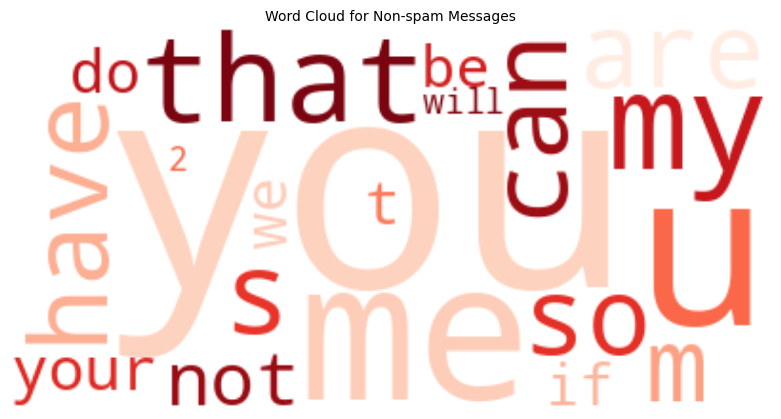

In [21]:
top_spam = top_words(df, 'v2', top_n=20, label=0)
create_wordcloud(top_spam, 'Non-spam')

EDA 5: Word Cloud for Spam Messages

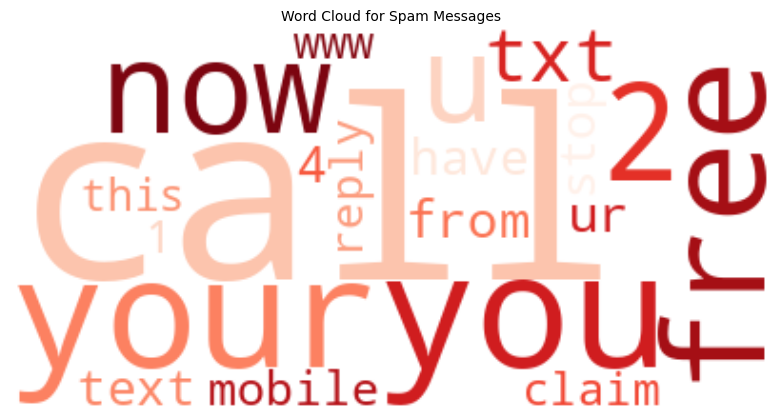

In [22]:
top_spam = top_words(df, 'v2', top_n=20, label=1)
create_wordcloud(top_spam, 'Spam')

# Preprocessing

Preprocessing 1: Lower case

Preprocessing 2: De-contractions Words

In [23]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [24]:
def contr_words(text, contractions_dict):
    text = str(text)
    for contraction, expansion in contractions_dict.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
    return text

In [25]:
df['v2'] = df['v2'].apply(lambda x: contr_words(x, contractions))

Preprocessing 3: Removing Special Characters

In [26]:
df['v2'] = df['v2'].str.replace(r'[^\w\s]', '', regex=True)

Preprocessing 4: Removing Stopwords

In [27]:
nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())  
    tokens_wo_stopwords = [word for word in tokens if word not in english_stopwords] 
    return ' '.join(tokens_wo_stopwords)

In [29]:
df['v2'] = df['v2'].apply(remove_stopwords)

Preprocessing 5: Stemming

In [30]:
ps = PorterStemmer()

def stem_text(text):
    words = str(text).lower().split()
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [31]:
df['v2'] = df['v2'].apply(stem_text)

# EDA-After Preprocessing

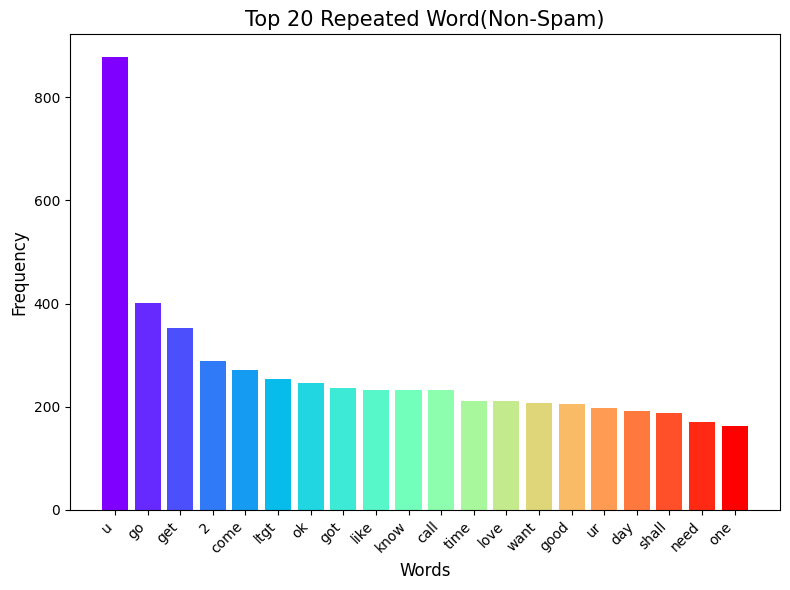

In [32]:
import matplotlib.cm as cm

top_non_spam = top_words(df, 'v2', top_n=20, label=0)
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(top_non_spam)))
plt.bar(
  [word[0] for word in top_non_spam], 
  [word[1] for word in top_non_spam], 
  color=colors
)
plt.title('Top 20 Repeated Word(Non-Spam)', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

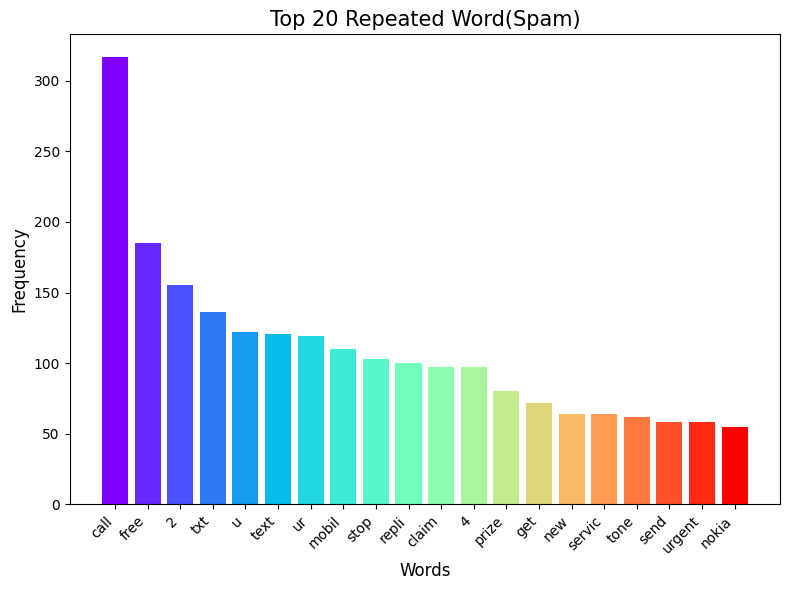

In [33]:
import matplotlib.cm as cm

top_non_spam = top_words(df, 'v2', top_n=20, label=1)
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(top_non_spam)))
plt.bar(
  [word[0] for word in top_non_spam], 
  [word[1] for word in top_non_spam], 
  color=colors
)
plt.title('Top 20 Repeated Word(Spam)', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

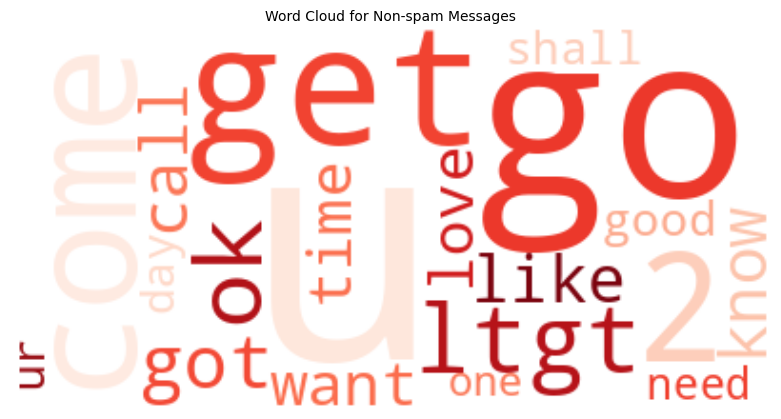

In [34]:
top_spam = top_words(df, 'v2', top_n=20, label=0)
create_wordcloud(top_spam, 'Non-spam')

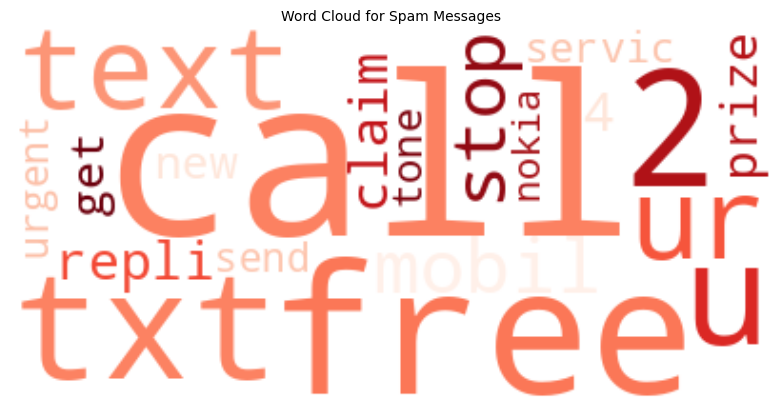

In [35]:
top_spam = top_words(df, 'v2', top_n=20, label=1)
create_wordcloud(top_spam, 'Spam')

# Feature Engineering

Feature Engineering 1: Extracting no. of words in a row.

In [36]:
def count_total_words(text):
    return len(word_tokenize(text))

In [37]:
df['num_words'] = df['v2'].apply(count_total_words)

In [38]:
df.head()

,v1,v2,num_words
0,0,go jurong point crazi avail bugi n great world...,16
1,0,ok lar joke wif u oni,6
2,1,free entri 2 wkli comp win fa cup final tkt 21...,23
3,0,u dun say earli hor u c alreadi say,9
4,0,nah think goe usf live around though,7


Heat Map

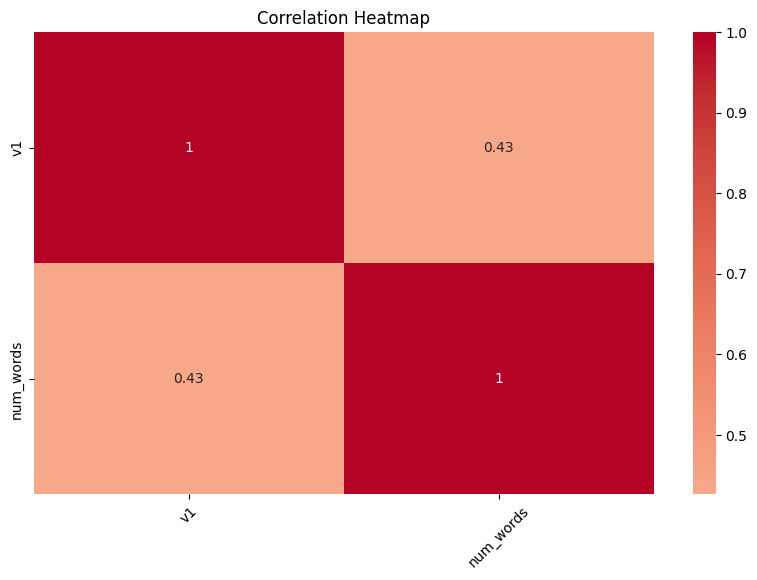

In [39]:
heat_map = df.drop(['v2'], axis=1)

correlation_matrix = heat_map.corr().round(4)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.show()

# Bag of Words

In [40]:
# vectorizer = CountVectorizer(
#     stop_words='english',
#     max_features=4000,
#     lowercase=True,
# )
# bow_matrix = vectorizer.fit_transform(df['v2'])
# feature_names = vectorizer.get_feature_names_out()

In [41]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=4000,
    lowercase=True,
)
bow_matrix = vectorizer.fit_transform(df['v2'])
feature_names = vectorizer.get_feature_names_out()

In [42]:
print(len(feature_names))

4000


In [43]:
bow_matrix.shape

(5163, 4000)

In [44]:
bow_matrix_df = pd.DataFrame(bow_matrix.toarray())

In [45]:
num_w_df = pd.DataFrame(df['num_words'])

In [46]:
bow_matrix_df.shape

(5163, 4000)

In [47]:
num_w_df.shape

(5163, 1)

In [48]:
# final_df = pd.concat([bow_matrix_df, num_w_df], axis=1)

In [49]:
bow_matrix_df = bow_matrix_df.reset_index(drop=True)
num_w_df = num_w_df.reset_index(drop=True)
final_df = pd.concat([bow_matrix_df, num_w_df], axis=1)

In [50]:
final_df = final_df.rename(str, axis="columns") 

In [51]:
final_df.shape

(5163, 4001)

# Train, Test, Split

In [52]:
X = final_df
y = df['v1']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modeling 1: Gradient Boosting Classifier 

In [54]:
gb_classifier = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

In [55]:
start_time = time.time()
gb_classifier.fit(X_train, y_train)
gb_training_time = time.time() - start_time
gb_pred = gb_classifier.predict(X_test)

In [56]:
print("Accuracy:", accuracy_score(y_test, gb_pred))
print("GB Training Time: {:.4f} seconds".format(gb_training_time))

Accuracy: 0.9506292352371732
GB Training Time: 7.2121 seconds


# Hyper Tunning - Gradient Boosting

In [57]:
# grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), 
#                             {'n_estimators': [100, 200], 
#                              'learning_rate': [0.01, 0.1], 
#                              'max_depth': [3, 4]}, 
#                             cv=5, scoring='accuracy')

In [58]:
# grid_search.fit(X_train, y_train)

In [59]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# print("Best Param:", grid_search.best_params_)
# # print(classification_report(y_test, y_pred))

In [60]:
gb_classifier = GradientBoostingClassifier(
    n_estimators=200, 
    learning_rate=0.1, 
    max_depth=4, 
    random_state=42
)

In [61]:
start_time = time.time()
gb_classifier.fit(X_train, y_train)
gb_training_time = time.time() - start_time
gb_pred = gb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, gb_pred))
print("GB Training Time: {:.4f} seconds".format(gb_training_time))

Accuracy: 0.9612778315585673
GB Training Time: 19.0002 seconds


# Modeling 2: KNN

In [62]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
knn_classifier.fit(X_train, y_train)
knn_training_time = time.time() - start_time
knn_pred = knn_classifier.predict(X_test)

In [63]:
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Training Time: {:.4f} seconds".format(knn_training_time))

Accuracy: 0.952565343659245
KNN Training Time: 0.0703 seconds


# Hyper Tunning - KNN

In [64]:
# grid_search = GridSearchCV(KNeighborsClassifier(), 
#                             {'n_neighbors': range(1, 21), 
#                              'weights': ['uniform', 'distance'],  
#                              'metric': ['euclidean', 'manhattan']}, 
#                             cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

In [65]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# print("Best Param:", grid_search.best_params_)
# print(classification_report(y_test, y_pred))

In [66]:
knn_classifier = KNeighborsClassifier(n_neighbors=6, metric='manhattan', weights='distance')
start_time = time.time()
knn_classifier.fit(X_train, y_train)
knn_training_time = time.time() - start_time
knn_pred = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Training Time: {:.4f} seconds".format(knn_training_time))

Accuracy: 0.9593417231364957
KNN Training Time: 0.0693 seconds


# Modeling 3: Random Forest

In [67]:
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
start_time = time.time()
rf_classifier.fit(X_train, y_train)
rf_training_time = time.time() - start_time
rf_pred = rf_classifier.predict(X_test)

In [68]:
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("RF Training Time: {:.4f} seconds".format(rf_training_time))

Accuracy: 0.9738625363020329
RF Training Time: 2.3649 seconds


# Hyper Tunning - Random Forest

In [69]:
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
#                             {'n_estimators': [50, 100, 200],
#                              'max_depth': [None, 10, 20],  
#                              'min_samples_split': [2, 5, 10], 
#                              'min_samples_leaf': [1, 2, 4]}, 
#                             cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

In [70]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# print("Best Parameters:", grid_search.best_params_)
# print(classification_report(y_test, y_pred))

In [71]:
rf_classifier = RandomForestClassifier(
    n_estimators=200, 
    min_samples_split = 5,
    min_samples_leaf = 1,
    max_depth = None,
)
start_time = time.time()
rf_classifier.fit(X_train, y_train)
rf_training_time = time.time() - start_time
rf_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("RF Training Time: {:.4f} seconds".format(rf_training_time))

Accuracy: 0.9719264278799613
RF Training Time: 4.5711 seconds


# Modeling 4: SVM

In [72]:
svm_classifier = SVC(random_state=42)
start_time = time.time()
svm_classifier.fit(X_train, y_train)
svm_training_time = time.time() - start_time
svm_pred = svm_classifier.predict(X_test)

In [73]:
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM  Training Time: {:.4f} seconds".format(svm_training_time))

SVM Accuracy: 0.888673765730881
SVM  Training Time: 7.0717 seconds


# Extracting Models

In [74]:
import joblib

In [75]:
# joblib.dump(gb_classifier, 'gb_model.joblib')
# joblib.dump(knn_classifier, 'knn_model.joblib')
# joblib.dump(rf_classifier, 'rf_model.joblib')
# joblib.dump(vectorizer, 'spam_vectorizer.joblib')

In [79]:
def predict_spam(text, contractions):
    loaded_model = joblib.load('gb_model.joblib')
    loaded_vectorizer = joblib.load('spam_vectorizer.joblib')
    
    text = text.lower()
    
    for contraction, expansion in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text.lower())
    english_stopwords = set(stopwords.words('english'))
    tokens_wo_stopwords = [word for word in tokens if word not in english_stopwords]
    text = ' '.join(tokens_wo_stopwords)
    
    ps = PorterStemmer()
    words = text.lower().split()
    stemmed_words = [ps.stem(word) for word in words]
    text = ' '.join(stemmed_words)
    
    num_words = len(word_tokenize(text))
    
    bow_matrix = loaded_vectorizer.transform([text])
    
    input_features = pd.DataFrame(bow_matrix.toarray())
    input_features['num_words'] = num_words
    input_features = input_features.rename(str, axis="columns")
    
    prediction = loaded_model.predict(input_features)
    
    return "Spam" if prediction[0] == 1 else "Not Spam"

Predicting

In [80]:
print(predict_spam("Free prize! Click here to claim now!", contractions))

Spam


In [81]:
print(predict_spam("Hi, how are you doing today?", contractions))

Not Spam
